## Stock prediction (buy/Sell signal)
Chiyuan Cheng (updated: 12/10/2019)


#### Objectives:
- Predict QQQ ETF stock trend (buy or sell) using historical stock data and technical indicators.

#### Updated Models (prototype)
- Instead of predicting signals, models predict cross-overs (i.e. ratio of short and long term trend).  These cross-overs are used to determine the signals of price moving up or down.
- Model: Building a 1D CNN to extract temporal features before feeding into LSTM. It seems to perform better than Stacked LSTM.

#### Reference:
- [Understanding the Average Directional Index (ADX) to Build Trading Strategies](https://medium.com/@arangana/understanding-the-average-directional-index-adx-to-build-trading-strategies-90726498f191)
- [Get Started with Using CNN+LSTM for Forecasting](https://towardsdatascience.com/get-started-with-using-cnn-lstm-for-forecasting-6f0f4dde5826)
- [A Gentle Introduction to LSTM Autoencoders](https://machinelearningmastery.com/lstm-autoencoders/)

- [Technical Analysis (TA) Indicators](https://technical-analysis-library-in-python.readthedocs.io/en/latest/) 
- Borovkova S, Tsiamas I. An ensemble of LSTM neural networks for high-frequency stock market classification. Journal of Forecasting. 2019;1–20. https://doi.org/10.1002/for.2585
- Hegazy O, Soliman OS, Salam MA. A Machine Learning Model for Stock Market Prediction. International Journal of Computer Science and Telecommunications. 2013; 17–23. https://www.ijcst.org/Volume4/Issue12/p4_4_12.pdf

In [66]:
print('Installing TA...')
!pip install ta
print('Installing TA-Lib...')
#!pip install TA-Lib
!pip install pyti


Installing TA...
Installing TA-Lib...


### Import Python Packages

In [0]:
from datetime import date
import ta
import pyti.directional_indicators  as ta_adx  #Average Directional Index
import pyti.volume_adjusted_moving_average  as ta_vwap

#import pandas_datareader.data as web
import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader


import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import seaborn as sns

from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook, show
from bokeh.transform import factor_cmap, factor_mark
from bokeh.layouts import column
from bokeh.models import HoverTool, ColumnDataSource, RangeTool, DatetimeTickFormatter

from sklearn.preprocessing import Normalizer, normalize, MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.metrics import categorical_accuracy
from keras.utils import to_categorical
import keras.backend as K

from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.optimizers import Adam
from keras.layers import BatchNormalization

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
 
%matplotlib inline


In [68]:
# Test GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### Load stock data

In [69]:
#Upload QQQ file
from google.colab import drive
from google.colab import files
#uploaded = files.upload()
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
path = '/content/drive/My Drive/ts_data/'
file_nme = 'AlphaVantageDaily_adjusted_qqq.csv' # QQQ stock data
etf = pd.read_csv(path+file_nme, infer_datetime_format=True,  index_col=['timestamp'])
etf.sort_index(inplace=True)
display(etf.head(3))
display(etf.tail(3))


,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
timestamp,,,,,,,,
1999-03-10,102.3,102.3,100.60,102.1,44.9877,2616000,0.0,1.0
1999-03-11,102.9,103.5,100.60,102.6,45.2080,4844300,0.0,1.0
1999-03-12,102.3,102.3,99.31,100.1,44.1065,4371800,0.0,1.0


,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
timestamp,,,,,,,,
2019-06-25,188.06,188.14,184.65,184.93,184.93,33921112,0.0,1.0
2019-06-26,186.13,187.33,185.49,185.79,185.79,22512628,0.0,1.0
2019-06-27,186.47,186.94,185.99,186.72,186.72,15889915,0.0,1.0


In [71]:
print('Start date:', etf.index.min(), '| End date:', etf.index.max(), '| Shape:', etf.shape)

Start date: 1999-03-10 | End date: 2019-06-27 | Shape: (5109, 8)


In [72]:
etf.describe().T

,count,mean,std,min,25%,50%,75%,max
open,5109.0,7.438699e+01,4.493983e+01,1.994000e+01,3.939000e+01,5.538000e+01,1.052900e+02,2.298000e+02
high,5109.0,7.501415e+01,4.524498e+01,2.053000e+01,3.968500e+01,5.587000e+01,1.059199e+02,2.329000e+02
low,5109.0,7.365319e+01,4.456079e+01,1.976000e+01,3.900000e+01,5.479000e+01,1.042100e+02,2.270000e+02
close,5109.0,7.437047e+01,4.495419e+01,2.006000e+01,3.935000e+01,5.538000e+01,1.051200e+02,2.300000e+02
adjusted_close,5109.0,6.647846e+01,4.246551e+01,1.767780e+01,3.507370e+01,4.896710e+01,9.014090e+01,1.906888e+02
volume,5109.0,6.996211e+07,5.292414e+07,1.097837e+06,3.017664e+07,6.009376e+07,9.444580e+07,6.165787e+08
dividend_amount,5109.0,2.142983e-03,2.436519e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.206000e-01
split_coefficient,5109.0,1.000196e+00,1.399046e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00


Stock Daily Chart

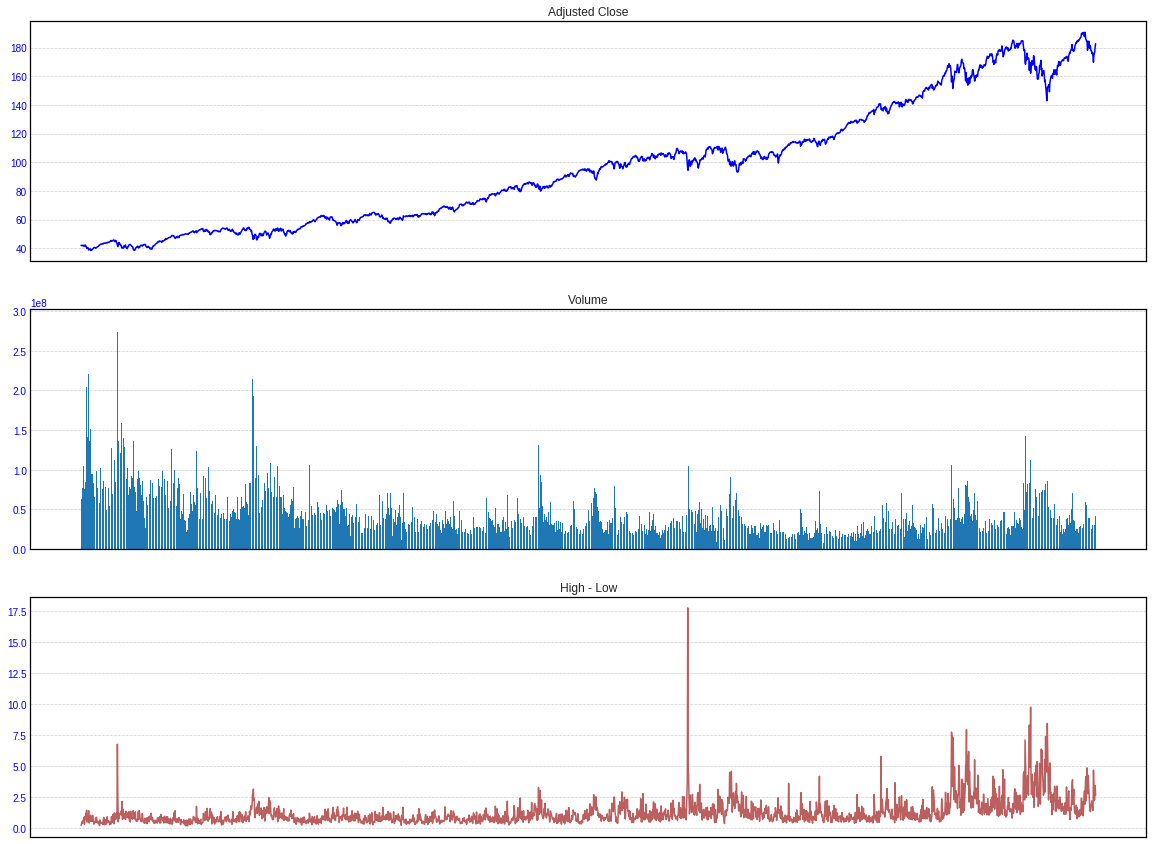

In [73]:
spine_color = 'black'
grid_color = '#D3D3D3'

# filter dates to select snapshot 
etf_snap = etf.loc['2010-01-01':'2019-06-10']
hi_lo = etf_snap.high-etf.low

fig = plt.figure(figsize=(20,15))
plt.style.use('seaborn-white')

ax1 = plt.subplot2grid((3,1), (0,0), rowspan=1, colspan=3)
ax1.plot(etf_snap.index, etf_snap.adjusted_close.dropna(),color='blue')
ax1.axes.get_xaxis().set_visible(False)
ax1.set_ylabel('', color = 'black')
ax1.set_title('Adjusted Close')

ax1.spines['bottom'].set_color(spine_color)
ax1.spines['top'].set_color(spine_color)
ax1.spines['left'].set_color(spine_color)
ax1.spines['right'].set_color(spine_color)

ax1.grid(True, color=grid_color, lw = 0.75, ls ='--')
ax1.tick_params(axis='y', colors='b')

ax2 = plt.subplot2grid((3,1), (1,0), rowspan=1, colspan=3)
ax2.bar(etf_snap.index, etf_snap.volume.dropna())
ax2.axes.get_xaxis().set_visible(False)
ax2.set_ylabel('', color = 'black')
ax2.set_title('Volume')

ax2.spines['bottom'].set_color(spine_color)
ax2.spines['top'].set_color(spine_color)
ax2.spines['left'].set_color(spine_color)
ax2.spines['right'].set_color(spine_color)

ax2.grid(True, color=grid_color, lw = 0.75, ls ='--')
ax2.tick_params(axis='y', colors='b')

    
ax3 = plt.subplot2grid((3,1), (2,0), rowspan=1, colspan=3)
ax3.plot(etf_snap.index, hi_lo.dropna(), color='brown', alpha=.75, ls='-')
ax3.axes.get_xaxis().set_visible(False)
ax3.set_ylabel('', color = 'black')
ax3.set_title('High - Low')

ax3.spines['bottom'].set_color(spine_color)
ax3.spines['top'].set_color(spine_color)
ax3.spines['left'].set_color(spine_color)
ax3.spines['right'].set_color(spine_color)

ax3.grid(True, color=grid_color, lw = 0.75, ls ='--')
ax3.tick_params(axis='y', colors='b')



### Technical Analysis (TA) Indicators
https://technical-analysis-library-in-python.readthedocs.io/en/latest/

*
The library has implemented 31 indicators:

Volume


* Accumulation/Distribution Index (ADI)
* On-Balance Volume (OBV)
* Chaikin Money Flow (CMF)
* Force Index (FI)
* Ease of Movement (EoM, EMV)
* Volume-price Trend (VPT)
* Negative Volume Index (NVI)

Volatility
* Average True Range (ATR)
* Bollinger Bands (BB)
* Keltner Channel (KC)
* Donchian Channel (DC)

Trend
* Moving Average Convergence Divergence (MACD)
* Average Directional Movement Index (ADX)
* Vortex Indicator (VI)
* Trix (TRIX)
* Mass Index (MI)
* Commodity Channel Index (CCI)
* Detrended Price Oscillator (DPO)
* KST Oscillator (KST)
* Ichimoku Kinkō Hyō (Ichimoku)

Momentum
* Money Flow Index (MFI)
* Relative Strength Index (RSI)
* True strength index (TSI)
* Ultimate Oscillator (UO)
* Stochastic Oscillator (SR)
* Williams %R (WR)
* Awesome Oscillator (AO) 

Others
* Daily Return (DR)
* Daily Log Return (DLR)
* Cumulative Return (CR)






Calculate TA features

In [74]:
etf_ta = ta.add_all_ta_features(etf, "open", "high", "low", "close", "volume", fillna=True)
print(etf.shape)
etf_ta.head()


/usr/local/lib/python3.6/dist-packages/ta/trend.py:543: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:547: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


(5109, 74)


,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-03-10,102.3,102.3,100.60,102.1,44.9877,2616000,0.0,1.0,2.000471e+06,2616000,0.764706,0.000000e+00,0.000000,0.000000,941456.902580,1000.000000,0.0,102.100000,102.100000,102.10,0.0,0.0,101.666667,101.666667,99.966667,0.0,0.0,102.1,102.1,1.0,1.0,0.000000,0.000000,0.000000,102.100000,102.100000,0.0,0.0,0.0,1.0,1.0,0.0,37.902822,1.000000,0.000000,-27.729528,372.856682,372.856682,0.000000,101.450,101.450,73.931609,73.496922,4.0,4.0,0.0,102.10,99.31,102.3,0.0,0.0,50.000000,50.0,100.000000,99.283912,88.235294,88.235294,-11.764706,0.0,102.1,0.0,37.285668,0.000000,0.000000
1999-03-11,102.9,103.5,100.60,102.6,45.2080,4844300,0.0,1.0,3.837964e+06,7460300,0.514452,2.422150e+06,35.918502,35.918502,999116.390347,1000.000000,0.0,102.850000,101.850000,102.35,0.0,0.0,101.950000,101.950000,99.650000,0.0,0.0,102.1,102.6,1.0,0.0,-0.039886,-0.007977,-0.031909,102.176923,102.137037,0.0,0.0,0.0,1.0,1.0,0.0,0.000956,2.109840,66.666667,-27.979528,376.218231,374.537456,1.680775,102.050,102.050,73.931609,73.496922,8.0,4.0,4.0,102.60,99.31,102.3,0.0,0.0,100.000000,50.0,100.000000,96.431992,68.965517,78.600406,-31.034483,0.0,102.6,0.0,0.489716,0.488521,0.489716
1999-03-12,102.3,102.3,99.31,100.1,44.1065,4371800,0.0,1.0,1.776346e+06,3088500,0.150129,5.147714e+05,-85.149138,-24.615318,-82802.030651,975.633528,0.0,103.760247,99.439753,101.60,0.0,0.0,101.490000,101.490000,98.960000,0.0,0.0,100.1,102.6,0.0,1.0,0.128749,0.019368,0.109381,101.857396,101.986145,0.0,0.0,0.0,1.0,1.0,0.0,-0.002272,3.285731,-100.000000,-27.229528,366.133584,371.736166,-5.602582,101.405,101.405,73.931609,73.496922,8.0,12.0,-4.0,102.30,99.31,102.3,0.0,1.0,15.662651,50.0,96.289015,89.448857,18.854415,58.685076,-81.145585,0.0,100.1,0.0,-2.436647,-2.466825,-1.958864
1999-03-15,100.9,103.1,99.81,103.0,45.3843,3184500,0.0,1.0,4.767259e+06,6273000,0.317466,1.760526e+06,67.153399,5.974255,-14267.099372,1003.898635,0.0,104.179350,99.720650,101.95,0.0,0.0,101.610000,101.610000,98.890000,0.0,0.0,100.1,103.0,1.0,0.0,0.028064,0.021107,0.006957,102.033182,102.061246,0.0,0.0,0.0,1.0,1.0,0.0,-0.002612,4.512567,46.153846,-27.579528,370.839752,371.512062,-0.672310,101.405,101.405,73.931609,73.496922,16.0,12.0,4.0,99.31,99.31,106.5,1.0,0.0,58.931311,50.0,94.393324,90.109471,88.066826,58.628919,-11.933174,0.0,103.0,0.0,2.897103,2.855930,0.881489
1999-03-16,103.4,104.3,102.30,103.9,45.7808,2452900,0.0,1.0,6.238999e+06,8725900,0.357137,1.824395e+06,150.434180,42.089236,113691.348554,1012.670565,0.0,104.871719,99.808281,102.34,0.0,0.0,101.988000,101.988000,99.412000,0.0,0.0,100.1,103.9,1.0,0.0,-0.122935,-0.007701,-0.115234,102.320384,102.197450,0.0,0.0,0.0,1.0,1.0,0.0,0.000723,5.657393,143.399090,-27.969528,376.083769,372.426404,3.657365,101.805,101.805,73.931609,73.496922,20.0,12.0,8.0,99.31,99.31,106.5,0.0,0.0,64.942539,50.0,93.225726,89.596424,91.983968,66.301736,-8.016032,0.0,103.9,0.0

In [75]:
# list of Technical Indicators
etf_ta.columns

Index(['open', 'high', 'low', 'close', 'adjusted_close', 'volume',
       'dividend_amount', 'split_coefficient', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbm', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch',
       'volatility_dchi', 'volatility_dcli', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_a',
       'trend_ichimoku_b', 'trend_visual_ichimoku_a',
       'trend_visual_ichimok

Statistical analysis for volumne features

In [76]:
stats=[]
colidx=[]
colnme=['count','mean','std','min','25%','50%','75%','max']

for c in etf_ta.columns:
  if 'volume' in c:
    stats.append(list(etf_ta[c].describe().reset_index().values[:,1]))
    colidx.append(c)

pd.DataFrame(stats, index=colidx, columns=colnme)


,count,mean,std,min,25%,50%,75%,max
volume,5109.0,6.996211e+07,5.292414e+07,1.097837e+06,3.017664e+07,6.009376e+07,9.444580e+07,6.165787e+08
volume_adi,5109.0,5.165643e+09,5.061118e+09,-1.240145e+09,2.162499e+08,3.867149e+09,1.001591e+10,1.407889e+10
volume_obv,5109.0,4.176255e+09,2.800512e+09,-8.081542e+08,1.068050e+09,5.590199e+09,6.558958e+09,7.696211e+09
volume_cmf,5109.0,6.702142e-02,1.568019e-01,-4.059914e-01,-4.325356e-02,6.526701e-02,1.750808e-01,7.647059e-01
volume_fi,5109.0,-3.218873e+06,2.484970e+07,-2.744120e+08,-8.888865e+06,1.451707e+06,8.266572e+06,1.327438e+08
volume_em,5109.0,-3.327182e-01,8.576363e+01,-5.409501e+03,-3.889069e-01,4.018465e-02,5.973638e-01,6.146464e+02
volume_sma_em,5109.0,-3.097369e-01,2.268653e+01,-4.395856e+02,-1.208860e-01,2.983243e-02,2.231816e-01,1.158933e+02
volume_vpt,5109.0,-6.789457e+04,2.812874e+06,-4.270211e+07,-6.004662e+05,6.046156e+04,6.182668e+05,3.528664e+07
volume_nvi,5109.0,9.612381e+03,1.334988e+04,9.360175e+02,1.590082e+03,3.204424e+03,1.159772e+04,6.755032e+04


### Feature Engineering
- Calculate the cross-over (short, long), which are trend related and the buy/sell signals
- cumulative return over a period
- 14-day ema /50-day ema cross-overs

In [15]:
price_change = etf.adjusted_close/etf.adjusted_close.shift(1) -1
price_change.describe()

count    5108.000000
mean        0.000431
std         0.017490
min        -0.092865
25%        -0.006582
50%         0.000970
75%         0.007949
max         0.168412
Name: adjusted_close, dtype: float64

Text(0.5, 1.0, 'Price Change')

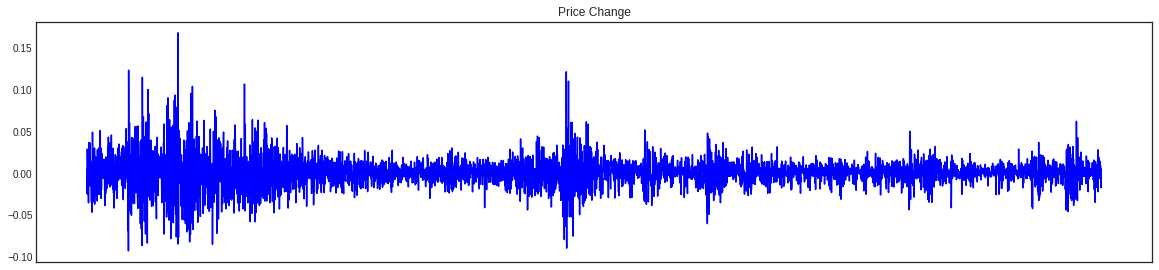

In [17]:
spine_color = 'black'
grid_color = '#D3D3D3'

fig = plt.figure(figsize=(20,15))
plt.style.use('seaborn-white')

ax1 = plt.subplot2grid((3,1), (0,0), rowspan=1, colspan=3)
ax1.plot(price_change,color='blue')
ax1.axes.get_xaxis().set_visible(False)
ax1.set_ylabel('', color = 'black')
ax1.set_title('Price Change')

In [0]:

def feature_engineer(data, short, mid, long):
  '''
  calculate the cross-over between two time perioid
  add adx and rsi
  '''
 
  # Calculate adaptive Moving average for short and long periods
  
 
  ema_s = data.adjusted_close.ewm(span=short).mean()
  ema_l = data.adjusted_close.ewm(span=long).mean()
  ema_m = data.adjusted_close.ewm(span=mid).mean()
  
  # Calculate cross-over

  ema_ratio = ema_m/ema_l
  ema_ratio_s = ema_s/ema_m
  
  adx = ta_adx.average_directional_index(data.close, data.high, data.low, 14)
  

  out=data.copy()
  

  #out['vwap'] = vwap5
 
  out['ema_s'] = ema_s
  out['ema_l'] = ema_l
  out['ema_m'] = ema_m
  out['adx'] = adx
  out['rsi'] = data.momentum_rsi.values
  
  out['ema_ratio'] = ema_ratio
  out['ema_ratio_s'] = ema_ratio_s
  
  return out[long:]
  

cross-over signal

In [78]:
etf_signal = feature_engineer(etf_ta, 5, 13, 48)
etf_signal.head(10)

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,...,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr,ema_s,ema_l,ema_m,adx,rsi,ema_ratio,ema_ratio_s
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-05-18,108.6,109.3,107.00,108.30,47.7196,4633900,0.0,1.0,3.035526e+07,-9296700,0.243719,-2.140273e+05,59.561061,2.382694,71070.214727,1264.416716,3.713050,112.387276,103.872724,108.1300,0.0,0.0,107.373333,107.373333,103.753333,0.0,0.0,104.40,113.2,0.0,0.0,-0.502106,-0.490417,-0.011689,107.954680,107.452574,11.009777,19.012943,20.068682,0.988615,...,-0.017078,0.063112,25.875629,16.322612,-1.2300,15.499170,27.086864,-11.587694,106.8475,105.8,106.6500,104.75,36.0,16.0,20.0,112.521847,97.88,112.521847,0.0,0.0,51.797013,50.235253,26.270449,62.756799,62.626263,55.630976,-37.373737,0.639853,105.152561,0.837989,-0.367985,-0.368664,6.072478,47.699731,47.228675,47.553943,11.099267,51.797013,1.006887,1.003066
1999-05-19,108.7,109.8,107.00,109.80,48.3805,3992800,0.0,1.0,3.434806e+07,-5303900,0.235957,6.721481e+05,17.531557,10.651646,38249.869141,1281.929413,3.621745,112.534645,104.075355,108.3050,0.0,0.0,107.630000,107.630000,104.360000,0.0,0.0,104.40,113.2,0.0,0.0,-0.612118,-0.514757,-0.097360,108.238576,107.626458,10.228177,18.949987,18.975542,1.038314,...,0.101533,0.065397,25.609332,35.823951,-3.1050,15.738079,22.190591,-6.452512,106.8475,105.8,106.6500,104.75,32.0,12.0,20.0,112.313410,97.88,112.313410,0.0,0.0,54.553484,58.367511,25.606373,65.452630,77.777778,69.023569,-22.222222,0.533971,105.209135,2.712816,1.385042,1.375538,7.541626,47.926654,47.282372,47.672076,10.297068,54.553484,1.008242,1.005340
1999-05-20,110.0,110.0,106.60,106.70,47.0146,2998600,0.0,1.0,3.152584e+07,-8302500,0.171970,-7.518245e+05,-11.338625,9.598904,-29357.988082,1245.736506,3.599571,112.444083,103.915917,108.1800,0.0,0.0,107.870000,107.870000,104.750000,0.0,0.0,104.40,113.2,0.0,0.0,-0.444040,-0.500614,0.056574,108.001872,107.557831,9.656718,17.689935,18.496068,1.049603,...,0.099206,0.063558,25.342446,-7.916021,0.2200,15.988030,18.890301,-2.902270,107.2725,105.8,106.7500,104.75,28.0,8.0,20.0,112.109142,97.88,112.109142,0.0,0.0,48.394230,52.125189,24.515030,58.280128,46.464646,62.289562,-53.535354,0.108382,105.239902,1.425856,-2.823315,-2.863937,4.505387,47.622636,47.269961,47.578115,9.726958,48.394230,1.006519,1.000936
1999-05-21,107.1,107.4,105.20,105.80,46.6180,5479300,0.0,1.0,2.903525e+07,-13781800,0.129820,-1.348902e+06,-80.302228,3.380831,-130877.078031,1245.736506,3.459614,112.172446,103.707554,107.9400,0.0,0.0,107.973333,107.973333,104.953333,0.0,0.0,104.40,113.2,0.0,0.0,-0.235501,-0.447591,0.212091,107.663122,107.427622,9.652265,16.906571,20.495017,0.992016,...,0.013972,0.057277,25.103421,-69.432684,-3.5400,13.981401,16.629947,-2.648546,107.2725,105.8,106.0750,104.75,24.0,4.0,20.0,111.908959,97.88,111.908959,0.0,0.0,46.744174,52.188402,23.385246,51.099003,37.373737,53.872054,-62.626263,0.068382,105.242498,-2.398524,-0.843486,-0.847064,3.623898,47.287757,47.239909,47.440910,9.768815,46.744174,1.004

#### Trading Range Using ADX (testing)

In [82]:
def trading_range(data, tol):
  '''
  incorporate adx to indicate strong trend when adx>24
  '''
  in_range = np.where(data.adx < 25, 1, 0)
  
  signal = np.where(data.ema_ratio - 1 > 0, 2, np.where(data.ema_ratio - 1 < 0, 1,0))
  
  out = pd.DataFrame()
  
  
  out['timestamp'] = data.index
  out['in_range'] = in_range
  out['signal'] = signal
  out['price'] = data.adjusted_close.values
  out['ema_s'] = data.ema_s.values
  out['ema_m'] = data.ema_m.values
  out['ema_l'] = data.ema_l.values
  out['ema_ratio'] = data.ema_ratio.values
  out['ema_ratio_s'] = data.ema_ratio_s.values
  out['adx'] = data.adx.values
  out['rsi'] = data.rsi.values
  out = out.set_index('timestamp', drop=True)
  
  return out

etf_range = trading_range(etf_signal, 0.001)
etf_range.groupby(['in_range','signal']).size()


in_range  signal
0         1          853
          2         1066
1         1          834
          2         2308
dtype: int64

Text(0.5, 1.0, 'Average Directional Index (ADX)')

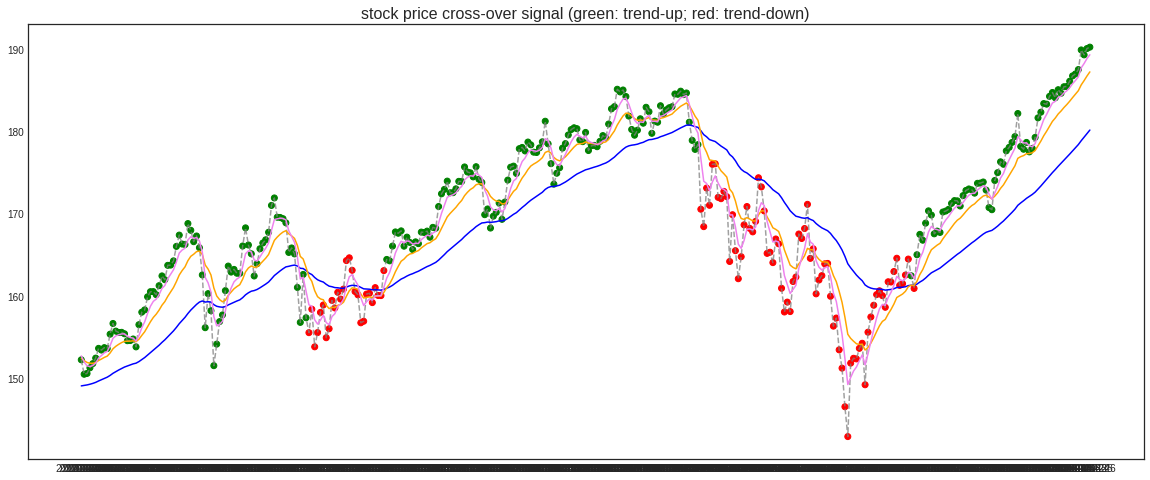

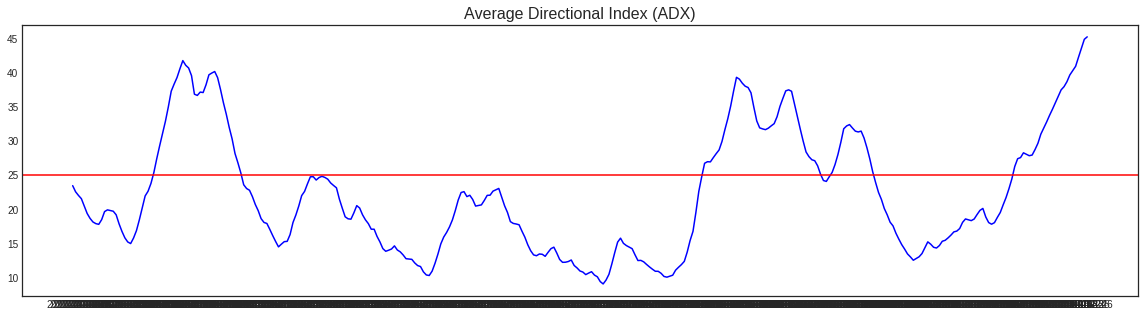

In [86]:
tol = 0.01

start = '2017-12-01'
end = '2019-04-27'

fig = plt.figure(figsize=(20,8))

signal = etf_range.signal[start:end]
in_range = etf_range.in_range[start:end]

#color = np.where((signal == 2) & (in_range == 0), 'g', np.where((signal == 1) & (in_range == 0), 'r', 'w'))
color = np.where((signal == 2), 'g', np.where((signal == 1), 'r', 'w'))
#marker = np.where(signal == 2, '^', np.where(signal == 1, 'o', '.'))

plt.plot(etf_range.price[start:end], color = 'grey', alpha = 0.75, ls ='--')
plt.plot(etf_range.ema_l[start:end], color = 'blue')
plt.plot(etf_range.ema_m[start:end], color = 'orange')
plt.plot(etf_range.ema_s[start:end], color = 'violet')
plt.scatter(etf_range[start:end].index, etf_range.price[start:end], marker = 'o', color=color)
plt.title('stock price cross-over signal (green: trend-up; red: trend-down)', fontsize=16)


fig = plt.figure(figsize=(20,5))
plt.plot(etf_range.adx[start:end], color = 'b')
plt.axhline(y=25, color='r', linestyle='-')
plt.title('Average Directional Index (ADX)', fontsize=16)




#### Cross over feature selection

In [0]:
def norm_vector(v):
    '''
    normalized vector (standarization)
    '''
    num=v-v.mean()
    den=np.sqrt(np.sum((v-v.mean())**2))
    return num/den

def norm_corr(x,y):
    '''
    calculate normalized cross-correlation
    '''
    norm_x = norm_vector(x)
    norm_y = norm_vector(y)
    return np.sum(norm_x*norm_y)
  

Feature selection using correlation

In [88]:
corr_hi = 0.4 
corr_lo = -0.4
corr_features = []

TA_group = [c for c in etf_signal.columns if 'trend' in c]
print('------------------------------------------------',"\n")    
for c in TA_group:
  corr = norm_corr(etf_signal[c], etf_signal['ema_ratio'])
  if (corr >= corr_hi)  or (corr <= corr_lo):
    corr_features.append(c)
    print(c,': ', corr)

TA_group = [c for c in etf_signal.columns if 'volume' in c]    
print('------------------------------------------------',"\n") 
for c in TA_group:
  corr = norm_corr(etf_signal[c], etf_signal['ema_ratio'])
  if (corr >= corr_hi)  or (corr <= corr_lo):
    corr_features.append(c)
    print(c,': ', corr)

TA_group = [c for c in etf_signal.columns if 'volatility' in c]    
print('------------------------------------------------',"\n") 
for c in TA_group:
  corr = norm_corr(etf_signal[c], etf_signal['ema_ratio'])
  if (corr >= corr_hi)  or (corr <= corr_lo):
    corr_features.append(c)
    print(c,': ', corr)

TA_group = [c for c in etf_signal.columns if 'momentum' in c]    
print('------------------------------------------------',"\n") 
for c in TA_group:
  corr = norm_corr(etf_signal[c], etf_signal['ema_ratio'])
  if (corr >= corr_hi)  or (corr <= corr_lo):
    corr_features.append(c)
    print(c,': ', corr)
    
TA_group = ['ema_s','ema_l', 'close', 'open', 'low','high', 'adjusted_close','others_dr', 'others_dlr', 'others_cr']    
print('------------------------------------------------',"\n") 
for c in TA_group:
  corr = norm_corr(etf_signal[c], etf_signal['ema_ratio'])
  if (corr >= corr_hi)  or (corr <= corr_lo):
    corr_features.append(c)
    print(c,': ', corr)

------------------------------------------------ 

trend_macd :  -0.4943505878035366
trend_macd_signal :  -0.5437862198642479
trend_adx_pos :  0.5843828912480192
trend_adx_neg :  -0.5221820888481521
trend_vortex_ind_pos :  0.5030962482353426
trend_vortex_ind_neg :  -0.5440801416691894
trend_vortex_ind_diff :  0.5367189981717573
trend_trix :  0.8382759811711381
trend_cci :  0.43971041089909024
trend_kst :  0.834489639465753
trend_kst_sig :  0.8353151383691045
trend_aroon_up :  0.6224565600613301
trend_aroon_down :  -0.5672820160662664
trend_aroon_ind :  0.659467893246834
------------------------------------------------ 

volume_cmf :  0.5304793876846525
------------------------------------------------ 

------------------------------------------------ 

momentum_rsi :  0.6342033722396445
momentum_mfi :  0.48208096332827505
momentum_tsi :  0.8241907668701278
momentum_stoch_signal :  0.4549308873035926
momentum_ao :  0.4143964127973442
momentum_roc :  0.4412502403792095
------------------

In [90]:
# features which is higly correlated with cross-over
corr_features

['trend_macd',
 'trend_macd_signal',
 'trend_adx_pos',
 'trend_adx_neg',
 'trend_vortex_ind_pos',
 'trend_vortex_ind_neg',
 'trend_vortex_ind_diff',
 'trend_trix',
 'trend_cci',
 'trend_kst',
 'trend_kst_sig',
 'trend_aroon_up',
 'trend_aroon_down',
 'trend_aroon_ind',
 'volume_cmf',
 'momentum_rsi',
 'momentum_mfi',
 'momentum_tsi',
 'momentum_stoch_signal',
 'momentum_ao',
 'momentum_roc']

#### Calculate Y

In [0]:


def y_ma(data, tol):
  

  in_range = np.where(data.adx < 18, 1, tol)
  #signal = np.where(data.ema_ratio - 1 > tol, 2, np.where(data.ema_ratio - 1 < 0, 1, tol))
  
  
  print('Identifying Signals: ')
  y = pd.DataFrame()
  
  y['timestamp'] = data.index
  
  y['signal'] = np.where(signal == 0, 0,
                  np.where((in_range == 0) & (signal == 1), 1,
                np.where((in_range == 0) & (signal == 2), 2, 0)))
  #                #np.where((in_range == 0) & (signal == 1), 3, 4))))
  
  #y['signal'] = signal
  
  y.set_index('timestamp', drop=True)

  print(y.groupby('signal').size())
  
  return y


def y_return(dr, signal, threshold):
  
  print('Calculating Return: ')
  
  signal = np.where(dr - 1 > threshold, 2, np.where(dr - 1 < 0, 1, 0))
  
  y = pd.DataFrame()
 
  y['signal'] = signal

  print(y.groupby('signal').size())
  
  return y



def y_ratio(data):
  
  return data['ema_ratio']

 

#### Split Data


In [0]:
def split_data(data, sr=0.8):
  
  # sr = sampling rate    
  
  cut = np.int(sr*len(data))
  
  test = data[cut:].copy()
  train = data[:cut].copy()
  
  print('\n','Data Splits:')
  print('Train Samples:', train.shape)
  print('Test Samples:', test.shape)
      
  return train, test 


- Create Y and Split X for Training
- After split, Standardization and PCA will be applied to Training Data Set
- Standardization and PCAs will be saved later to be applied to Validation and Test


In [94]:
sr = 0.8
short = 5
mid = 13
long = 48

# Create X

etf_x = feature_engineer(etf_ta, short, mid, long)

# Create Y

etf_y = y_ratio(etf_x)
#etf_y = y_ma(etf_x, 0.02)
 
print('\n','X/Y:', etf_x.shape, etf_y.shape)


train_x, test_x = split_data(etf_x, sr)
train_y, test_y = split_data(etf_y, sr)


 X/Y: (5061, 81) (5061,)

 Data Splits:
Train Samples: (4048, 81)
Test Samples: (1013, 81)

 Data Splits:
Train Samples: (4048,)
Test Samples: (1013,)


In [95]:
etf_x.columns

Index(['open', 'high', 'low', 'close', 'adjusted_close', 'volume',
       'dividend_amount', 'split_coefficient', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbm', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch',
       'volatility_dchi', 'volatility_dcli', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_a',
       'trend_ichimoku_b', 'trend_visual_ichimoku_a',
       'trend_visual_ichimok

#### Feature Selection via PCA

In [0]:

# Standardize Data


def data_standard(data, TAgroup):  
    
  x_scaler = StandardScaler().fit(train_x[TAgroup])
  x_scaled = x_scaler.fit_transform(data[TAgroup])
  
  return x_scaled


# Fit PCA per TA group

def data_pca(TAgroup, var_cut):
  
  x_pca=PCA().fit(train_x[TAgroup])
  
  variance = 0
  count = 0
  
  for value in x_pca.explained_variance_ratio_ :
    
    if variance < var_cut:
        variance += value
        count += 1
  
  #print(variance, count)
  return x_pca, count


# Extract PCAs per TA group


def pca_select(data, var_cut):
  
  Volume = ['volume_adi', 'volume_obv','volume_cmf', 'volume_fi','volume_em', 'volume_vpt', 'volume_nvi']
  Price = ['open', 'high', 'low', 'close', 'adjusted_close', 'vwap', 'ema_m', 'ema_l']
  Volatility = ['volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_kcc','volatility_kch', 'volatility_kcl', 'volatility_dch', 'volatility_dcl']
  Trend = ['adx', 'trend_macd', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx', 'trend_trix','trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst']
  Momentum = ['momentum_rsi', 'momentum_mfi', 'momentum_tsi','momentum_uo', 'momentum_stoch', 'momentum_wr','momentum_ao']
  Returns = ['others_dr', 'others_dlr', 'others_cr']
  Others = ['dividend_amount', 'split_coefficient','volume','ema_ratio']
  #Crossover = ['cross_5_20', 'cross_20_50', 'cross_14_48']
  
  TAgroups = [Price, Volume, Returns, Volatility, Trend, Momentum, Others]

  for i,g in enumerate(TAgroups):
    
    x_scaled = data_standard(data, g)  
    x_pca, x_cnt = data_pca(g, var_cut)  
    x_out = x_pca.fit_transform(x_scaled)   
    
    if i == 0:
      
      x_std = x_out[:, :x_cnt]
      
    else:
      
      x_std = np.concatenate([x_std, x_out[:, :x_cnt]], axis=1)
      
    print(g, x_cnt)

  print('PCA-Tansformed: ', x_std.shape)

  return x_std


#### PCA transformation X features

In [97]:
select_features = corr_features+['adx']

print('\n','Training:')
#train_x_std = pca_select(train_x, 1)
train_x_std = data_standard(train_x, select_features)
print(train_x_std.shape)

print('\n','Test:')
#test_x_std = pca_select(test_x, 1)
test_x_std = data_standard(test_x, select_features)
print(test_x_std.shape)


 Training:
(4048, 22)

 Test:
(1013, 22)


#### Sub-sequences

In [0]:
def create_sequence(x, y, lookback, window, start):

  xseq = []
  yseq = []
  xidx = []
  yidx = []
  

  for i in range(lookback, x.shape[0]):

    if i+ lookback < x.shape[0]:

      xseq.append(np.array(x[i-lookback:i]))
      xidx.append(i+start)
      
      #yseq.append(np.array(y[(i+1):(i+window+1)]))
      yseq.append(np.array(y.iloc[window+i]))
      yidx.append(window+i+start)

  print('\n','Created Sequences: length = ', len(xseq))
  
  return np.array(xseq), np.array(yseq), xidx, yidx


def build_model_data(x, y, lookback, window, start):
  
  xs, ys, ix, iy = create_sequence(x, y, lookback, window, start)
  #ys = to_categorical(ys) 
  
  ys = ys.reshape(len(ys))
  xs = xs.reshape(len(xs), lookback, xs.shape[2])
  
  print('\n','Sequence Data:', xs.shape, ys.shape)
  
  return xs, ys, ix, iy



#### Build Data for Model Training

In [100]:
window = 3
lookback = 14


# Create Data for Model Training
print('Training:')
train_x_seq, train_y_seq, train_x_idx, train_y_idx = build_model_data(train_x_std, train_y, lookback, window, 0)

print()
print('Test:')
test_x_seq, test_y_seq, test_x_idx, test_y_idx = build_model_data(test_x_std, test_y, lookback, window, len(train_x))


# loss function - penalizes loss when signs are opposite
# https://codeburst.io/neural-networks-for-algorithmic-trading-volatility-forecasting-and-custom-loss-functions-c030e316ea7e


def mae_loss(y_true, y_pred):
    alpha = 100.
    loss = K.switch(K.less(y_true * y_pred, 0), \
        alpha*y_pred**2 - K.sign(y_true)*y_pred + K.abs(y_true), \
        K.abs(y_true - y_pred)
        )
    return K.mean(loss, axis=-1)
  

Training:

 Created Sequences: length =  4020

 Sequence Data: (4020, 14, 22) (4020,)

Test:

 Created Sequences: length =  985

 Sequence Data: (985, 14, 22) (985,)


### Model Building -  Cross Ratios

In [103]:
# check the first 5 idx
print(train_x_idx[:5], train_y_idx[:5])
print(test_x_idx[:5], test_y_idx[:5]) 
print('\n',test_y_seq[:5], test_y[:5])

[14, 15, 16, 17, 18] [17, 18, 19, 20, 21]
[4062, 4063, 4064, 4065, 4066] [4065, 4066, 4067, 4068, 4069]

 [1.00077049 1.00382806 1.00785481 1.01146904 1.01429474] timestamp
2015-06-19    1.005655
2015-06-22    1.006824
2015-06-23    1.007827
2015-06-24    1.008072
2015-06-25    1.008019
Name: ema_ratio, dtype: float64


#### 1. Model Building - CNN-LSTM

In [130]:
from numpy.random import seed
seed(43)
from tensorflow import set_random_seed
set_random_seed(43)


window = 3
dr = 0.25
adam = Adam(lr=0.0001)

n_features = train_x_seq.shape[2]
n_timesteps = train_x_seq.shape[1]
n_seqs = 2
n_steps = np.int(n_timesteps/n_seqs)

neurons = 128

# define model

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=neurons, kernel_size=3, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(Conv1D(filters=neurons, kernel_size=3, activation='relu')))
#model.add(Dropout(dr))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(neurons, return_sequences=False))
#model.add(Dropout(dr))
#model.add(LSTM(36))
#model.add(Dropout(dr))
#model.add(BatchNormalization())
model.add(Dense(1))
model.compile(optimizer=adam, loss=mae_loss)
print(model.summary())

# fit LSTM network

n_epochs = 30
n_batch = 32

train_x_subseq = train_x_seq.reshape((train_x_seq.shape[0], n_seqs, n_steps, n_features))
test_x_subseq = test_x_seq.reshape((test_x_seq.shape[0], n_seqs, n_steps, n_features))

epoch_history = model.fit(train_x_subseq, train_y_seq, epochs=n_epochs, 
                          batch_size=n_batch, 
                          validation_data=(test_x_subseq, test_y_seq), verbose=-1, shuffle=False)


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_23 (TimeDis (None, None, 5, 128)      8576      
_________________________________________________________________
time_distributed_24 (TimeDis (None, None, 3, 128)      49280     
_________________________________________________________________
time_distributed_25 (TimeDis (None, None, 1, 128)      0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, None, 128)         0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 189,569
Trainable params: 189,569
Non-trainable params: 0
_______________________________________________

Plot loss Error
-------------------------------------------
Model Evaluation - Confusion Matrix
-------------------------------------------
[[222  36 108]
 [  5   5  26]
 [  7  10 566]]
              precision    recall  f1-score   support

 Below Cross       0.95      0.61      0.74       366
       Cross       0.10      0.14      0.11        36
 Above Cross       0.81      0.97      0.88       583

    accuracy                           0.81       985
   macro avg       0.62      0.57      0.58       985
weighted avg       0.83      0.81      0.80       985



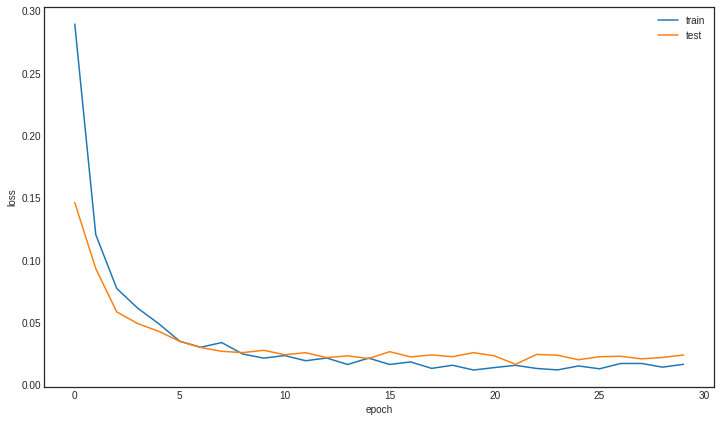

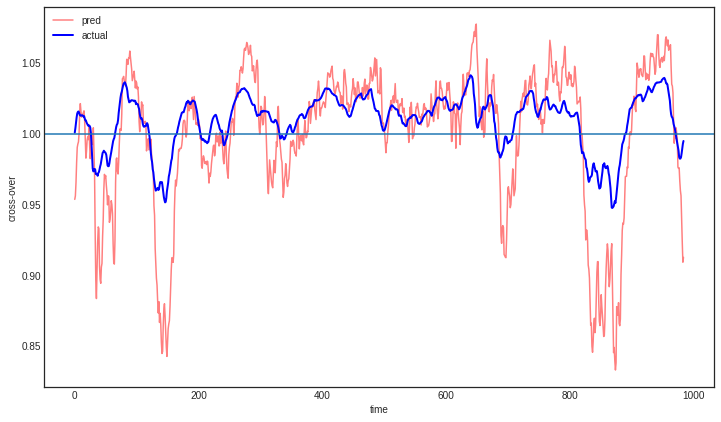

In [131]:
spine_color = '#808080'
grid_color = '#D3D3D3'

print('Plot loss Error')
print('-------------------------------------------')

fig = plt.figure(figsize=(12,7))

plt.style.use('seaborn-white')

# plot history
plt.plot(epoch_history.history['loss'], label='train')
plt.plot(epoch_history.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epoch');plt.ylabel('loss')

print('Model Evaluation - Confusion Matrix')
print('-------------------------------------------')
fig = plt.figure(figsize=(12,7))

y_pred = model.predict(test_x_subseq)
y_pred = y_pred.reshape(len(y_pred))
y_true = test_y_seq.reshape(len(y_pred))

plt.plot(y_pred, color='red', alpha=0.5, label='pred')
plt.plot(y_true, color='blue', lw=2, label='actual')
plt.axhline(y=1)
plt.legend()
plt.xlabel('time');plt.ylabel('cross-over')


pred_signal = np.where(y_pred - 1 > 0.005, 1, np.where(y_pred - 1 < 0, -1, 0))
true_signal = np.where(y_true - 1 > 0.005, 1, np.where(y_true - 1 < 0, -1, 0))

print(confusion_matrix(pred_signal, true_signal))
target_names = ['Below Cross', 'Cross', 'Above Cross']
print(classification_report(pred_signal, true_signal, target_names=target_names))


In [132]:
print(test_x_idx[3:9], test_y_idx[:6])
print(y_true[:6], y_pred[:6])
etf_range[4065:4070].head()

[4065, 4066, 4067, 4068, 4069, 4070] [4065, 4066, 4067, 4068, 4069, 4070]
[1.00077049 1.00382806 1.00785481 1.01146904 1.01429474 1.01532825] [0.9535762  0.95604587 0.96540153 0.97958404 0.9903121  0.9926756 ]


,in_range,signal,price,ema_s,ema_m,ema_l,ema_ratio,ema_ratio_s,adx,rsi
timestamp,,,,,,,,,,
2015-07-15,1,2,106.2328,105.165752,104.566194,104.485689,1.000770,1.005734,18.936304,58.174003
2015-07-16,1,2,107.7342,106.021901,105.018767,104.618282,1.003828,1.009552,19.050586,63.809659
2015-07-17,1,2,109.3222,107.122001,105.633543,104.810278,1.007855,1.014091,20.050497,68.624989
2015-07-20,1,2,109.6976,107.980534,106.214122,105.009761,1.011469,1.016631,21.346426,69.652810
2015-07-21,1,2,109.6302,108.530423,106.702134,105.198350,1.014295,1.017135,22.549790,69.214532


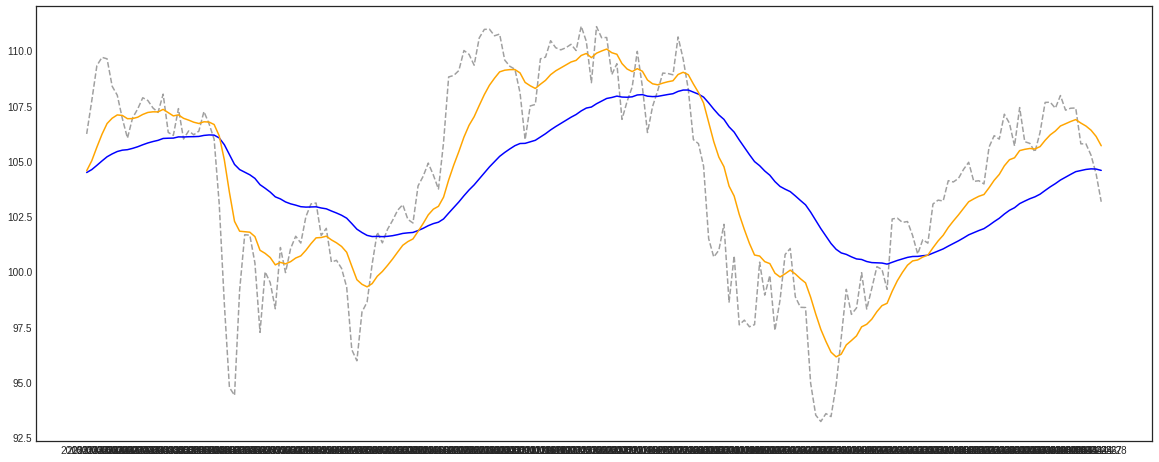

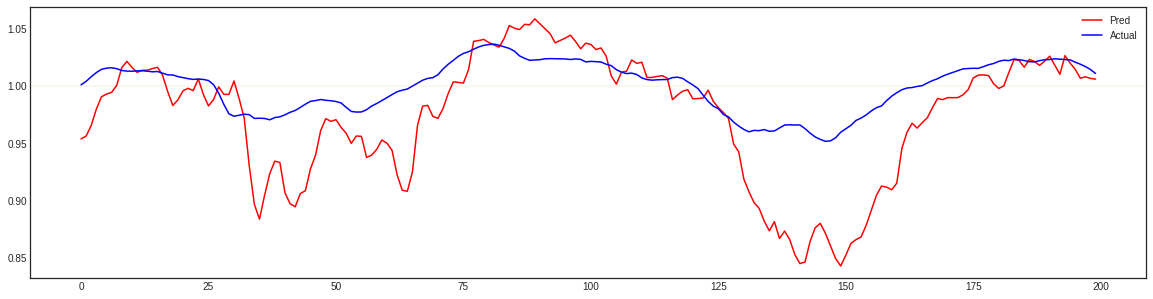

In [133]:
ref = 3
steps=200

start = test_x_idx[ref]
end = test_x_idx[ref+steps]


fig = plt.figure(figsize=(20,8))


plt.plot(etf_range.price[start:end], color = 'grey', alpha = 0.75, ls ='--')
plt.plot(etf_range.ema_l[start:end], color = 'blue')
plt.plot(etf_range.ema_m[start:end], color = 'orange')#plt.plot(etf_range.ema_s[start:end], color = 'violet')


#plt.scatter(etf_range[start:end].index, etf_range.price[start:end], marker = 'o', color=color)

fig = plt.figure(figsize=(20,5))

plt.plot(y_pred[0:steps], color = 'red', label='Pred')
plt.plot(y_true[0:steps], color = 'blue', label = 'Actual')
plt.axhspan(.999,1.001, facecolor = 'beige', alpha=0.5)
plt.legend()


#### 2. CNN-LSTM 

In [134]:
# CNN+LSTM - Single-Steps Encoder Output


from numpy.random import seed
seed(2019)

from tensorflow import set_random_seed
set_random_seed(201907)

window = 3
dr = 0.2
adam = Adam(lr=0.0001)

n_features = train_x_seq.shape[2]
n_timesteps = train_x_seq.shape[1]
n_seqs = 2
n_steps = np.int(n_timesteps/n_seqs)

neurons = 64


model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(1))
model.add(LSTM(neurons, return_sequences=True))
#model.add(LSTM(36, return_sequences=True))
model.add(TimeDistributed(Dense(neurons)))
model.add(TimeDistributed(Dense(1)))

model.compile(loss=mae_loss, optimizer=adam)
print(model.summary())

n_epochs = 25
n_batch = 32

train_y_tseq = train_y_seq.reshape(train_y_seq.shape[0], 1, 1)
test_y_tseq = test_y_seq.reshape(test_y_seq.shape[0], 1, 1)

epoch_history = model.fit(train_x_seq, train_y_tseq, epochs=n_epochs, batch_size=n_batch, validation_data=(test_x_seq, test_y_tseq), verbose=2, shuffle=False)


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 12, 64)            4288      
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 10, 64)            12352     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 320)               0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 1, 320)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 1, 64)             98560     
_________________________________________________________________
time_distributed_27 (TimeDis (None, 1, 64)           

Plot loss Error
-------------------------------------------
Model Evaluation - Confusion Matrix
-------------------------------------------


ValueError: ignored

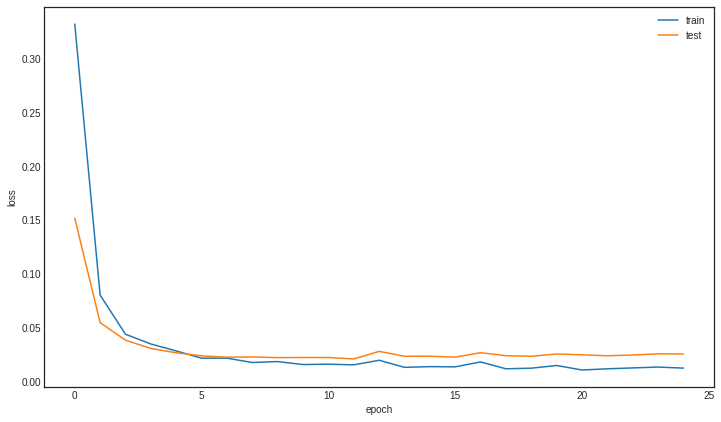

<Figure size 864x504 with 0 Axes>

In [135]:
spine_color = '#808080'
grid_color = '#D3D3D3'

print('Plot loss Error')
print('-------------------------------------------')

fig = plt.figure(figsize=(12,7))

plt.style.use('seaborn-white')

# plot history
plt.plot(epoch_history.history['loss'], label='train')
plt.plot(epoch_history.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epoch');plt.ylabel('loss')

print('Model Evaluation - Confusion Matrix')
print('-------------------------------------------')
fig = plt.figure(figsize=(12,7))

y_pred = model.predict(test_x_subseq)
y_pred = y_pred.reshape(len(y_pred))
y_true = test_y_seq.reshape(len(y_pred))

plt.plot(y_pred, color='red', alpha=0.5, label='pred')
plt.plot(y_true, color='blue', lw=2, label='actual')
plt.axhline(y=1)
plt.legend()
plt.xlabel('time');plt.ylabel('cross-over')


pred_signal = np.where(y_pred - 1 > 0.005, 1, np.where(y_pred - 1 < 0, -1, 0))
true_signal = np.where(y_true - 1 > 0.005, 1, np.where(y_true - 1 < 0, -1, 0))

print(confusion_matrix(pred_signal, true_signal))
target_names = ['Below Cross', 'Cross', 'Above Cross']
print(classification_report(pred_signal, true_signal, target_names=target_names))


In [0]:

ref = 3
steps=200

start = test_x_idx[ref]
end = test_x_idx[ref+steps]


fig = plt.figure(figsize=(20,8))

#color = np.where((signal == 2) & (in_range == 0), 'g', np.where((signal == 1) & (in_range == 0), 'r', 'w'))
#color = np.where((signal == 2), 'g', np.where((signal == 1), 'r', 'w'))
#marker = np.where(signal == 2, '^', np.where(signal == 1, 'o', '.'))

plt.plot(etf_range.price[start:end], color = 'grey', alpha = 0.75, ls ='--')
plt.plot(etf_range.ema_l[start:end], color = 'blue')
plt.plot(etf_range.ema_m[start:end], color = 'orange')#plt.plot(etf_range.ema_s[start:end], color = 'violet')


#plt.scatter(etf_range[start:end].index, etf_range.price[start:end], marker = 'o', color=color)

fig = plt.figure(figsize=(20,5))

plt.plot(y_pred[0:steps], color = 'r', label='Pred')
plt.plot(y_true[0:steps], color = 'b', label = 'Actual')
plt.axhspan(.999,1.001, facecolor = 'beige', alpha=0.5)
plt.legend()

### 3. Stacked-LSTM

In [0]:

from numpy.random import seed
seed(2019)

from tensorflow import set_random_seed
set_random_seed(201907)

window = 3
dr = 0.2
adam = Adam(lr=0.0001)

n_features = train_x_seq.shape[2]
n_timesteps = train_x_seq.shape[1]
n_seqs = 2
n_steps = np.int(n_timesteps/n_seqs)


model = Sequential()
model.add(LSTM(72, return_sequences= True, kernel_initializer='uniform', input_shape=(n_timesteps,n_features)))
#model.add(Dropout(0.25))
model.add(LSTM(48, return_sequences= True, kernel_initializer='uniform'))
#model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(loss=mae_loss, optimizer=adam)
print(model.summary())

n_epochs = 25
n_batch = 32

train_y_tseq = train_y_seq.reshape(train_y_seq.shape[0], 1, 1)
test_y_tseq = test_y_seq.reshape(test_y_seq.shape[0], 1, 1)

epoch_history = model.fit(train_x_seq, train_y_tseq, epochs=n_epochs, batch_size=n_batch, validation_data=(test_x_seq, test_y_tseq), verbose=2, shuffle=False)


ValueError: ignored

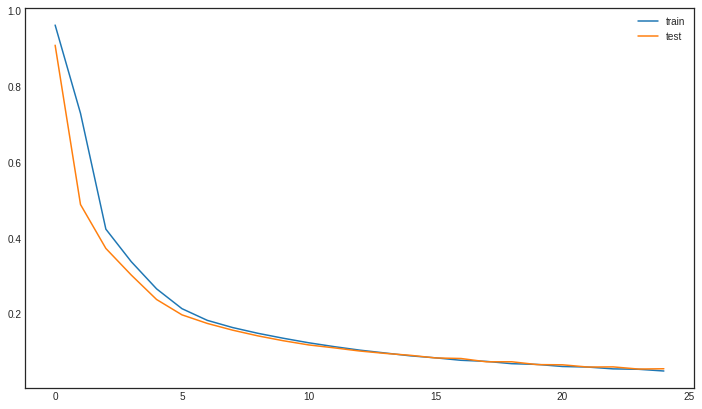

<Figure size 864x504 with 0 Axes>

In [128]:
spine_color = '#808080'
grid_color = '#D3D3D3'

print('Plot loss Error')
print('-------------------------------------------')

fig = plt.figure(figsize=(12,7))

plt.style.use('seaborn-white')

# plot history
plt.plot(epoch_history.history['loss'], label='train')
plt.plot(epoch_history.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epoch');plt.ylabel('loss')

print('Model Evaluation - Confusion Matrix')
print('-------------------------------------------')
fig = plt.figure(figsize=(12,7))

y_pred = model.predict(test_x_subseq)
y_pred = y_pred.reshape(len(y_pred))
y_true = test_y_seq.reshape(len(y_pred))

plt.plot(y_pred, color='red', alpha=0.5, label='pred')
plt.plot(y_true, color='blue', lw=2, label='actual')
plt.axhline(y=1)
plt.legend()
plt.xlabel('time');plt.ylabel('cross-over')


pred_signal = np.where(y_pred - 1 > 0.005, 1, np.where(y_pred - 1 < 0, -1, 0))
true_signal = np.where(y_true - 1 > 0.005, 1, np.where(y_true - 1 < 0, -1, 0))

print(confusion_matrix(pred_signal, true_signal))
target_names = ['Below Cross', 'Cross', 'Above Cross']
print(classification_report(pred_signal, true_signal, target_names=target_names))

ValueError: ignored

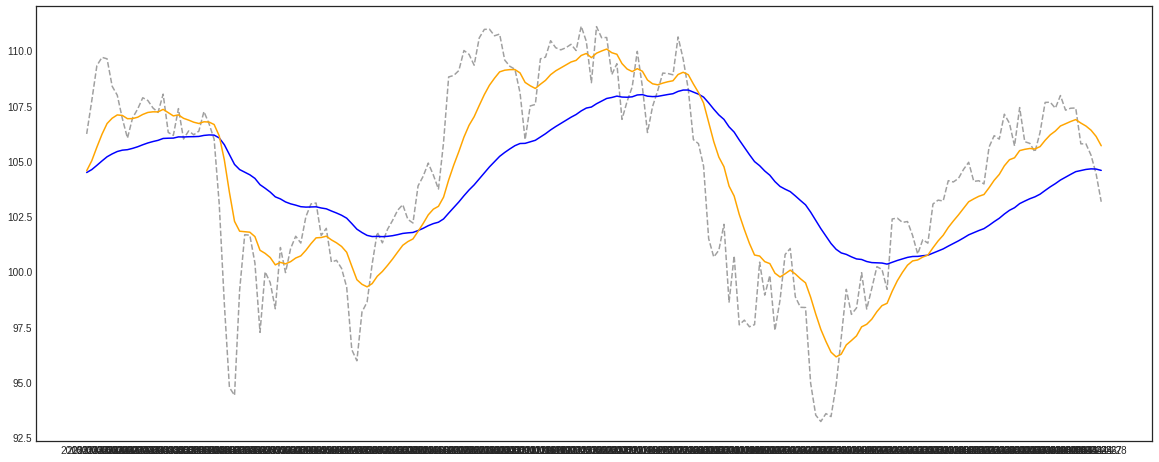

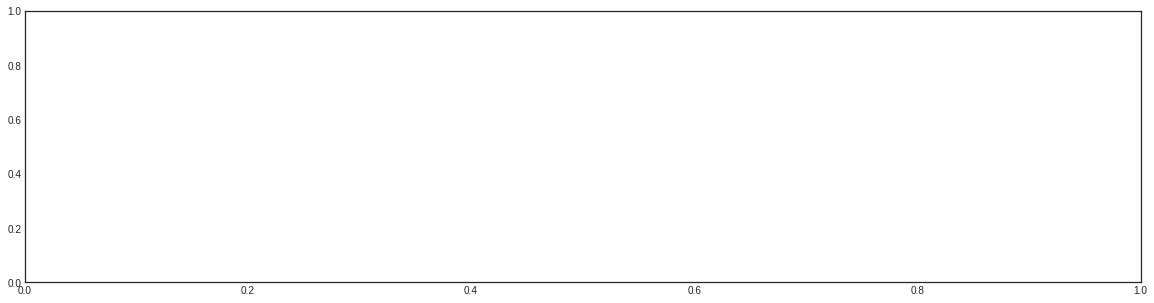

In [129]:

ref = 3
steps=200

start = test_x_idx[ref]
end = test_x_idx[ref+steps]


fig = plt.figure(figsize=(20,8))

#color = np.where((signal == 2) & (in_range == 0), 'g', np.where((signal == 1) & (in_range == 0), 'r', 'w'))
#color = np.where((signal == 2), 'g', np.where((signal == 1), 'r', 'w'))
#marker = np.where(signal == 2, '^', np.where(signal == 1, 'o', '.'))

plt.plot(etf_range.price[start:end], color = 'grey', alpha = 0.75, ls ='--')
plt.plot(etf_range.ema_l[start:end], color = 'blue')
plt.plot(etf_range.ema_m[start:end], color = 'orange')#plt.plot(etf_range.ema_s[start:end], color = 'violet')


#plt.scatter(etf_range[start:end].index, etf_range.price[start:end], marker = 'o', color=color)

fig = plt.figure(figsize=(20,5))

plt.plot(y_pred[0:steps], color = 'r', label='Pred')
plt.plot(y_true[0:steps], color = 'grey', label = 'Actual')
plt.axhspan(.999,1.001, facecolor = 'beige', alpha=0.5)
plt.legend()


8